In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# Module 11 Lab - Model Evaluation

## Directions


The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN685.648@gmail.com the official email for the course or ask questions in the Lab discussion area on Blackboard.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
Please follow the directions and make sure you provide the requested output. Failure to do so may result in a lower grade even if the code is correct or even 0 points.
</div>

1. Show all work/steps/calculations using Code and Markdown cells.
2. Submit your notebook (.ipynb).
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")


# load whatever other libraries you need including models.py
import models

## Model Evaluation and Improvement

As we saw in both the Linear Regression and Logistic Regression modules, there is a Statistician's view of Model Evaluation (and perhaps, Improvement) and a Machine Learning view of Model Evaluation and Improvement.

We'll be working with the **insurance data**.

**1. Load the data, perform your transformations, and using the Bootstrap version of the Linear Regression function, estimate your final model from Lab 10 and show the Bootstrap results**

Let's use the model produced at the end of the Lab 10 solution:

"charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children"

Let's load up the data, and create the transformations listed

In [4]:
data = pd.read_csv("insurance.csv")

data["age_sq"]       = data.age * data.age
data["smoke_yes"]    = pd.get_dummies(data.smoker, prefix="smoke").smoke_yes
data["male"]         = pd.get_dummies(data.sex).male
data["bmi_above_30"] = (data.bmi > 30).map({True: 1, False: 0})
data

,age,sex,bmi,children,smoker,region,charges,age_sq,smoke_yes,male,bmi_above_30
0,19,female,27.900,0,yes,southwest,16884.92400,361,1,0,0
1,18,male,33.770,1,no,southeast,1725.55230,324,0,1,1
2,28,male,33.000,3,no,southeast,4449.46200,784,0,1,1
3,33,male,22.705,0,no,northwest,21984.47061,1089,0,1,0
4,32,male,28.880,0,no,northwest,3866.85520,1024,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,2500,0,1,1
1334,18,female,31.920,0,no,northeast,2205.98080,324,0,0,1
1335,18,female,36.850,0,no,southeast,1629.83350,324,0,0,1
1336,21,female,25.800,0,no,southwest,2007.94500,441,0,0,0


In [5]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children"
final = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(final)

Our results are indeed pretty good. 

**2. Perform three rounds of 10-fold cross validation, estimating $R^2$ and $\sigma$ each round. Using the results for the test data, calculate 95% Bootstrap estimates of the credible intervals for each.** Comment on these intervals and the intervals from above. Are the average values different? Are the intervals different?

To do this, we'll use sklearn's `cross_val_score`. However, first we need to get our model into a form that sklearn can take in and evaluate. 

In [15]:
y, X = patsy.dmatrices(model, data, return_type="matrix")
reg = linear.LinearRegression()

In [16]:
from sklearn.model_selection import cross_val_score, RepeatedKFold

In [34]:
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
R2s = cross_val_score(estimator = reg, X = X, y = y, cv = cv)
R2s

array([0.88200657, 0.89374155, 0.86889218, 0.85295221, 0.94917338,
       0.86017784, 0.84655537, 0.77446399, 0.83321713, 0.87561323,
       0.79893548, 0.94441111, 0.81031815, 0.92460551, 0.90966819,
       0.86769227, 0.84683167, 0.836579  , 0.90736098, 0.85525215,
       0.92950911, 0.94280255, 0.87651198, 0.92745154, 0.83359276,
       0.79143157, 0.84175431, 0.74746667, 0.85269734, 0.88589089])

As we can see, `RepeatedKFold` did the 10 splits 3 times.

sklearn's `LinearRegression` uses $R^2$ as its scoring method, so the numbers we see above are the various $R^2$ values for each fold. But we need both $R^2$ and $\sigma$, so let's define our own scoring function that calculates $\sigma$ and combine those scores with our $R^2$ scores.

In [35]:
def calc_sigma(model, X, y):
    result = {}
    coefficients = model.coef_[0]

    y_hat = model.predict(X)
    residuals = y - y_hat
    
    sum_squared_error = sum(e ** 2 for e in residuals)[0]

    n = len(residuals)
    k = len(coefficients)

    sigma = np.sqrt(sum_squared_error / (n - k))
    return sigma

In [36]:
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
sigmas = cross_val_score(estimator = reg, X = X, y = y, cv = cv, scoring = calc_sigma)

Now that we have results for both (and both started with the same random seed so they give the same splits), we can carry out bootstrapping to get our results. 

In [37]:
def bootstrap_sample(data, f, n=100):
    m = len(data)
    return np.array(
        [f(np.random.choice(data, len(data), replace=True)) for _ in range(n)]
    )

In [38]:
R2_posterior    = bootstrap_sample(data = R2s   , f = np.mean, n = 500)
sigma_posterior = bootstrap_sample(data = sigmas, f = np.mean, n = 500)

In [39]:
stats.mstats.mquantiles(R2_posterior, prob = [0.025, 0.975])

array([0.8471807 , 0.88556733])

The 95% BCI for the $R^2$ of our model is 0.847 to 0.886

In [50]:
stats.mstats.mquantiles(sigma_posterior, prob = [0.025, 0.975])

array([4163.39668023, 4735.3879571 ])

The 95% BCI for the $\sigma$ of our model is 4163 to 4735

**3. Using Learning Curves and $\sigma$ determine if more data will improve the estimation of the model.**

In [53]:
from collections import defaultdict

def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def mse( errors):
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return np.sqrt((1.0/n) * squared_error)

def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len(data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]:
                # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever
                # increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results

def sse(results):
    errors = results['residuals']
    n = len(errors)
    squared_error = sum(e**2 for e in errors)
    return np.sqrt((1.0/n)*squared_error)

def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2*s)
        lower.append( m - 2*s)
    return keys, lower, mean, upper

def plot_learning_curves( results, metric, desired=None, zoom=False, credible=True):
    figure = plt.figure(figsize=(10,6))
    
    axes = figure.add_subplot(1, 1, 1)
    
    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)
    
    axes.plot( xs, train_mean, color="steelblue", label="train")
    axes.plot( xs, test_mean, color="firebrick", label="test")
    if credible:
        axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25)
        axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25)
        
    if desired:
        if type(desired) is tuple:
            axes.axhline((desired[0] + desired[1])/2.0, color="gold", label="desired")
            axes.fill_between( xs, desired[1], desired[0], color="gold", alpha=0.25)
        else:
            axes.axhline( desired, color="gold", label="desired")
    
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")
    
    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))
    
    plt.show()
    plt.close()

In [55]:
results = learning_curves(models.linear_regression, model, data, sse)

KeyError: 'model'

In [58]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

TypeError: estimator should be an estimator implementing 'fit' method, <module 'sklearn.linear_model' from '/home/natemcintosh/miniconda3/envs/en685648/lib/python3.8/site-packages/sklearn/linear_model/__init__.py'> was passed

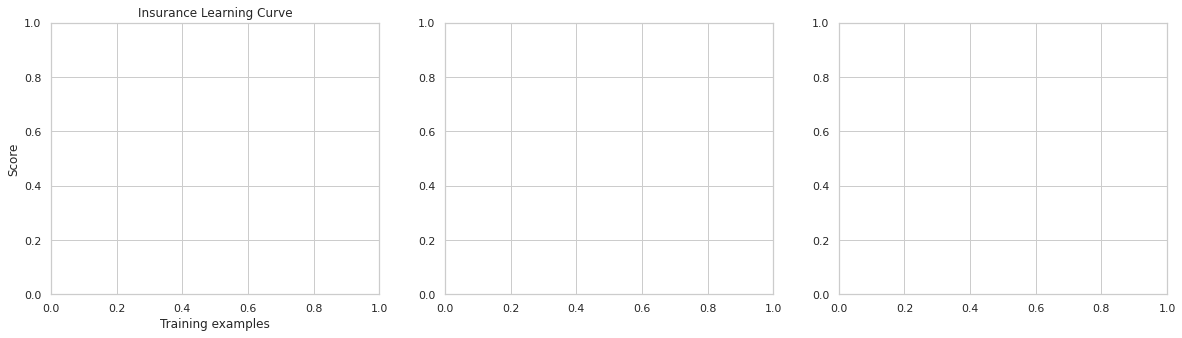

In [59]:
plot_learning_curve(estimator=linear, title="Insurance Learning Curve", X=X, y=y, cv=10)

**4. It was shown that `age_sq` improved the performance of the model. Perhaps a different polynomial would have been better. Generate Validation Curves for `age` = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5] and select the best transformation.**

**5. Using Ridge Regression to estimate a model for the insurance data. Compare it with your final Linear Regression model.** (If you get far ahead, you may need to write your own function. Here are the sklearn docs: http://scikit-learn.org/stable/modules/linear_model.html)